In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

In [2]:
# Fuction that evaluates waveform equation depending on waveform type selection
def wf_eq(wf_type, amp, width, t):
    
    samps = t.size
    
    if wf_type == 'Rect':
        '''
        Depending on what updates first (fig_out or width sliders) there is a
        change width could be temporarily smaller than # of samples, creating an error
        this shouldn't happen if there was only one .observe per widget, but since I am using
        .interative_output(). To fix this, need to strip that function and create my own where
        .observes() happen one by one (and only once) and call functions that update everything that
        needs to be updated by that widget.
        In the meantime, setting width=samps if width is smaller than samps is an easy fix.
        '''
        if width > samps: 
            width = samps
        init_del = int(np.floor((samps-width)/2))
        fin_del = samps-width-init_del
        sig = np.zeros(init_del)
        sig = np.append(sig,amp*np.ones(width))
        sig = np.append(sig, np.zeros(fin_del))
        
    elif wf_type == 'Sine':
        sig = amp*np.sin(2*np.pi*width*t-np.pi)
        
    elif wf_type == 'Cosine':
        sig = amp*np.cos(2*np.pi*width*t-np.pi)
        
    elif wf_type == 'Gaussian':
        sig = amp*np.exp(-1/2*((t-max(t)/2)/width)**2)
        
    elif wf_type == 'Gaussian Derivative':
        sig = -(t-max(t)/2)*np.exp(-1/2*((t-max(t)/2)/width)**2)
        sig = amp*sig/max(sig)
    else:
        sig = np.zeros(samps)
    return sig

In [3]:
# function that generates waveforms depending on input selected
def sig_gen(wf_in, i_wf, q_wf, samples, i_amp, q_amp, i_width, q_width):
    
    width = 1 # scaling in x. For sine/cos is equivalent to frequency
    
    t = np.linspace(0,samples,samples)
    
    if wf_in == 'Custom Waveform':
        i_sig = wf_eq(i_wf,i_amp,i_width,t)
        q_sig = wf_eq(q_wf,q_amp,q_width,t)
    else:
        i_sig = np.zeros(t.size)
        q_sig = np.zeros(t.size)

    return t, i_sig, q_sig

In [4]:
# Function that returns maximum allowable quadrature amplitude
def find_qamp_max(i_sign, q_sign):
    '''
    TO DO: This function is NOT general enough! There are still cases where qamp is too larg
    Need to find the qmax for which the norm is < 0 throughout the whole samples span.
    Probably need to find MAX of ABS of I and Q, look for indices at those locations (instead of just Q),
    and then find q_max based on that.
    For this, it is then important to pass the correct q_sign signal (not just a scaled ver of it)
    '''
    
    q_max_val = max(abs(q_sign)) # Find maximum of the abs of quad signal (taking abs to account for minimum too)
    q_max_ind = [i for i, x in enumerate(abs(q_sign)) if x == q_max_val] # indices of maxima in abs quad signal
    
    iamp_max = max(abs(i_sign[q_max_ind]))   # evaluate in-phase sig at indices of quad max,
                                            # and find largest value
    
    qamp_max = np.sqrt(1-iamp_max**2)       # qamp max needed so norm of I and Q is not larger than 1
    
    return qamp_max

In [5]:
# Waveform plotting function
def plot_wf(wf_in, i_wf, q_wf, samples, i_amp, q_amp, i_width, q_width):
    
    t, i_sig, q_sig = sig_gen(wf_in, i_wf, q_wf, samples, i_amp, q_amp, i_width, q_width)
    
    fig, (ax0,ax1) = plt.subplots(1,2, figsize=(7,3), sharex=True)
    ax0.set_xlabel('time t/dt')
    ax1.set_xlabel('time t/dt')
    ax0.set_ylabel('In-Phase Amplitude')
    ax1.set_ylabel('Quadrature Amplitude')
    ax0.set_xlim(0,samples)
    ax1.set_xlim(0,samples)
    ax0.set_ylim(-(abs(i_amp)+0.1),abs(i_amp)+0.1)
    ax1.set_ylim(-(abs(q_amp)+0.1),abs(q_amp)+0.1)
    ax0.step(t, i_sig, 'r')
    ax1.step(t, q_sig, 'b')
    fig.tight_layout(pad=2.0)
    
    '''
    TO DO: 
    1. Need to decide how to set the min res of y axes (set_ylim) based on backend amp resolution
    Also need to do yset_ticks so plot is not jumping around when changing amplitude
    2. To update quadrature max amplitude, need info about the in-phase signal. Can't seem to be able
    to get this info by using .interactive_output() and constructing the signals inside the passed function.
    Therefore, might need to have the signal construction function outside, and pass numpy arrays thru 
    interactive_output() as fixed widgets (might be better this way). 
    '''

In [6]:
def plot_schedule(qb_val,appnd):
    global my_schedule
    
    if len(my_schedule) == 0:
        i_sig = np.array([0])
        q_sig = np.array([0])
    else:
        i_sig = np.real(my_schedule)
        q_sig = np.imag(my_schedule)
        
    samps = i_sig.size
    
    '''TO DO: NEED TO CHECK HOW time is treated (does time goes to samples-1?)'''
    t = np.linspace(0,samps,samps)
    
    fig, axs = plt.subplots(figsize=(7.5,3))
    axs.set_xlabel('time t/dt')
    axs.set_ylabel('Amplitude')
    axs.set_xlim(0,samps)
    axs.set_ylim(-1.1,1.1)
    axs.step(t, i_sig, 'r')
    axs.fill_between(t, i_sig, color='r', alpha=0.2, step='pre')
    axs.step(t, q_sig, 'b')
    axs.fill_between(t, q_sig, color='b', alpha=0.2, step='pre')
    

In [7]:
'''TO DO: Created dictionaries with properties of each backend to 
          avoid having to use different many different variables for each backend throughout the code'''

# Parameters
backend_lst = ['Armonk', 'Almaden'] # Backends that support Pulse
#qb_num_lst = [1, 20]               # Number of qubits supported by each backend (Armonk: 1, Almaden: 20)

armonk_qb_lst = ['q0']                            # List of qubits supported by Armonk
almaden_qb_lst = ['q'+str(q) for q in range(20)]  # List of qubits supported by Almaden

my_pulse = np.array([])
my_schedule = np.array([]) # Array to store full schedule waveform

input_lst = ['Import from Native', 'Import from Array', 
             'Custom Waveform']                              # Waveform input options
waveform_lst = ['Gaussian', 'Gaussian Derivative', 'Rect',
                'Gaussian Square','DRAG', 'Sine', 'Cosine']  # Custom waveforms available



'''TO DO: Find out what samples and amplitude resolution is for each backend'''
amp_res_val = 0.01 # Amplitude resolution
samples_val = 640  # Number of initial samples


'''TO DO: Maybe use arrays below as global vars instead of creating them locally every time I info from them'''
#i_sig_arr = np.zeros(samples_val)                  # Array with in-phase signal amplitudes 
#q_sig_arr = np.zeros(samples_val)                  # Array with quadrature signal amplitudes


### UI Left Panel (I/O) ###

# Dropdown menu for backend
backend_dd = widgets.Dropdown(options=backend_lst, 
                              layout=widgets.Layout(width='auto'),
                              continuous_update=False,
                              disabled=False)

# Dropdown menu for waveform input
wf_in_dd = widgets.Dropdown(options=input_lst, 
                            layout=widgets.Layout(width='auto'),
                            continuous_update=False,
                            disabled=False)

# Dropdown menu for type of in-phase wavefunction (enabled when custom waveform is selected)
i_wf_dd = widgets.Dropdown(options=waveform_lst, 
                          layout=widgets.Layout(width='auto'),
                          description='In-Phase:',
                          continuous_update=False,
                          disabled=True)

# Dropdown menu for type of quadrature wavefunction (enabled when custom waveform is selected)
q_wf_dd = widgets.Dropdown(options=waveform_lst,
                          layout=widgets.Layout(width='auto'),
                          description='Quadrature:',
                          continuous_update=False,
                          disabled=True)

# Button to save pulse to array
save_btn = widgets.Button(description='Save',
                          icon='check',
                          button_style='', # 'success', 'info', 'warning', 'danger' or ''
                          disabled=False)

# Dropdown menu for to select qubit to append pulse to
qb_val_dd = widgets.Dropdown(options=armonk_qb_lst,
                             layout=widgets.Layout(width='150px'),
                             description='Append to:',
                             continuous_update=False,
                             disabled=False)

# Button to append pulse to schedule
append_btn = widgets.Button(description='Append',
                            icon='',
                            button_style='', # 'success', 'info', 'warning', 'danger' or ''
                            disabled=False)


# Combines all dropdown menus in a left panel

left_panel = widgets.VBox([widgets.Label("Backend:"), backend_dd,
                           widgets.Label("Input:"), wf_in_dd,
                           widgets.Label("Waveform:"), i_wf_dd, q_wf_dd,
                           widgets.Label("Pulse Output:"), 
                           widgets.HBox([widgets.VBox([widgets.Label("Save to \'my_pulse\' "),qb_val_dd]),
                                         widgets.VBox([save_btn,append_btn])]),
                           widgets.Label("Schedule Output:")])


### UI Top Pannel Waveform Control (enabled when custom waveform is selected) ###

# Slider to select number of samples
'''TO DO: Need to check what the valid resolution is for pulse amplitudes for each backend, 
dont think there is a restriction though.'''
samples_sldr = widgets.IntSlider(value=samples_val, 
                                 description='Samples:', 
                                 min=10, max=2*samples_val, step=2,
                                 continuous_update=False,
                                 disabled=True)

# Slider for In-phase frequency,width,sigma (Get's updated depending on type of signal)
i_width_sldr = widgets.IntSlider(value=np.floor(samples_val/2), 
                                 description='I Width', 
                                 min=1, max=2*samples_val, step=1,
                                 continuous_update=False,
                                 disabled=True)

# Slider for quadrature frequency,width,sigma (Get's updated depending on type of signal)
q_width_sldr = widgets.IntSlider(value=np.floor(samples_val/2), 
                                 description='Q Width', 
                                 min=1, max=2*samples_val, step=1,
                                 continuous_update=False,
                                 disabled=True)


'''TO DO: maybe create dictionary containing different width options for ease of selection
Need to decide if I need a "delay/centering" option.'''

# Slider for in-phase amplitude (from -1 to 1)
i_amp_sldr = widgets.FloatSlider(value=0.5, 
                                 description='I Amplitude', 
                                 min=-1, max=1, step=amp_res_val,
                                 continuous_update=False,
                                 disabled=True)

# Slider for quadrature amplitude (Starts from -1 to 1, but gets updated based on value of in-phase amp)
# This is because Pulse only accepts steps with max amplitude of R(I,Q) = 1
q_amp_sldr = widgets.FloatSlider(value=0.5, 
                                 description='Q Amplitude', 
                                 min=-1, max=1, step=amp_res_val,
                                 continuous_update=False,
                                 disabled=True)


# Combines time-related sliders in a box
time_panel = widgets.HBox([i_width_sldr,q_width_sldr])

# Combines amplitude sliders in a box
amp_panel = widgets.HBox([i_amp_sldr,q_amp_sldr])



# Top panel with all waveform control sliders
top_panel = widgets.VBox([samples_sldr,time_panel,amp_panel])

### Fixed parameters ###

# fixed widget element to control appending updates
append_fxd = widgets.fixed(value=0)

In [8]:
### UI interactions ###

# Enable waveform editing when 'Custom Waveform' is selected as input
def update_wf_dd_disabled(*args):
    if wf_in_dd.value == 'Custom Waveform':
        i_wf_dd.disabled = False
        q_wf_dd.disabled = False
        samples_sldr.disabled = False
        i_amp_sldr.disabled = False
        q_amp_sldr.disabled = False
        i_width_sldr.disabled = False
        q_width_sldr.disabled = False
    else:
        i_wf_dd.disabled = True
        q_wf_dd.disabled = True
        samples_sldr.disabled = True
        i_amp_sldr.disabled = True
        q_amp_sldr.disabled = True
        i_width_sldr.disabled = True
        q_width_sldr.disabled = True
        
wf_in_dd.observe(update_wf_dd_disabled, 'value')

# Change number of min/max samples based on backend selected
'''TO DO: Right now, min/max/value samples below were manually plugged in, 
but need to get them from actual backends.'''
def update_samples(*args):
    global my_schedule

    if backend_dd.value == 'Almaden':
        samples_sldr.min = 10
        samples_sldr.value = 160
        samples_sldr.max = 320
    if backend_dd.value == 'Armonk':
        samples_sldr.min = 10
        samples_sldr.value = 640
        samples_sldr.max = 1280        
    
    my_schedule = np.array([])
    append_fxd.value = (append_fxd.value+1)%2
    
backend_dd.observe(update_samples, 'value')

# Change number of qubits based on backend selected.
def update_qubits(*args):
    if backend_dd.value == 'Almaden':
        qb_val_dd.options = almaden_qb_lst
    if backend_dd.value == 'Armonk':
        qb_val_dd.options = armonk_qb_lst

backend_dd.observe(update_qubits, 'value')

# Updates max allowable value of Quadrature amplitude
def update_qamp_max(*args):
    if wf_in_dd.value == 'Custom Waveform':

        # Here to calculate q_sig I am passing an arbitrary amplitude (10*amp_res_val) because q_sig is only needed
        # to find the indices of the maxima of the currently-selected function. If I pass the current
        # q_amp (q_amp_sldr.value), there is a change it will be zero and no correct maxima are found
        t, i_sig, q_sig = sig_gen(wf_in_dd.value, i_wf_dd.value, q_wf_dd.value, 
                                  samples_sldr.value, i_amp_sldr.value, 10*amp_res_val,
                                  i_width_sldr.value, q_width_sldr.value)

        q_amp_max = find_qamp_max(i_sig,q_sig)

        if q_amp_max < amp_res_val:
            q_amp_sldr.value = 0
            q_amp_sldr.disabled = True
        else:
            q_amp_sldr.max = q_amp_max
            q_amp_sldr.min = -q_amp_max
            q_amp_sldr.disabled = False


wf_in_dd.observe(update_qamp_max, 'value')
i_wf_dd.observe(update_qamp_max, 'value')
q_wf_dd.observe(update_qamp_max, 'value')
samples_sldr.observe(update_qamp_max, 'value')
i_amp_sldr.observe(update_qamp_max, 'value')
q_amp_sldr.observe(update_qamp_max, 'value')


# Updates in-phase width/sigma/frequency slider
def update_i_width_sldr(*args):
    if i_wf_dd.value == 'Sine' or i_wf_dd.value == 'Cosine':
        i_width_sldr.description='I Periods'
        i_width_sldr.value = 1
        i_width_sldr.min = 1
        i_width_sldr.max = 10
    elif i_wf_dd.value == 'Rect':
        i_width_sldr.description='I Width'
        i_width_sldr.value = np.floor(samples_sldr.value/2)
        i_width_sldr.min = 1
        i_width_sldr.max = samples_sldr.value
    else:
        i_width_sldr.description='I Sigma'
        i_width_sldr.value = np.floor(samples_sldr.value/10)
        i_width_sldr.min = 1
        i_width_sldr.max = samples_sldr.value
        
i_wf_dd.observe(update_i_width_sldr, 'value')
samples_sldr.observe(update_i_width_sldr, 'value')

# Updates quadrature width/sigma/frequency slider
def update_q_width_sldr(*args):
    if q_wf_dd.value == 'Sine' or q_wf_dd.value == 'Cosine':
        q_width_sldr.description='Q Periods'
        q_width_sldr.value = 1
        q_width_sldr.min = 1
        q_width_sldr.max = 10
    elif q_wf_dd.value == 'Rect':
        q_width_sldr.description='Q Width'
        q_width_sldr.value = np.floor(samples_sldr.value/2)
        q_width_sldr.min = 1
        q_width_sldr.max = samples_sldr.value
    else:
        q_width_sldr.description='Q Sigma'
        q_width_sldr.value = np.floor(samples_sldr.value/10)
        q_width_sldr.min = 1
        q_width_sldr.max = samples_sldr.value


q_wf_dd.observe(update_q_width_sldr, 'value')
samples_sldr.observe(update_q_width_sldr, 'value')


def on_save_clicked(b):
    
    global my_pulse
    
    if wf_in_dd.value == 'Custom Waveform':
        t, i_sig, q_sig = sig_gen(wf_in_dd.value, i_wf_dd.value, q_wf_dd.value, 
                                  samples_sldr.value, i_amp_sldr.value, q_amp_sldr.value,
                                  i_width_sldr.value, q_width_sldr.value)
        
        my_pulse = i_sig + 1j*q_sig

save_btn.on_click(on_save_clicked)

def on_append_clicked(b):
    
    global my_schedule
    
    if wf_in_dd.value == 'Custom Waveform':
        t, i_sig, q_sig = sig_gen(wf_in_dd.value, i_wf_dd.value, q_wf_dd.value, 
                                  samples_sldr.value, i_amp_sldr.value, q_amp_sldr.value,
                                  i_width_sldr.value, q_width_sldr.value)
        
        my_pulse = i_sig + 1j*q_sig
        my_schedule = np.concatenate((my_schedule,my_pulse))
        append_fxd.value = (append_fxd.value+1)%2
    
append_btn.on_click(on_append_clicked)

# Interactive figure
wf_fig_out = widgets.interactive_output(plot_wf, 
                                        {'wf_in':wf_in_dd, 
                                         'i_wf':i_wf_dd, 
                                         'q_wf':q_wf_dd,
                                         'samples':samples_sldr,
                                         'i_amp':i_amp_sldr,
                                         'q_amp':q_amp_sldr,
                                         'i_width':i_width_sldr,
                                         'q_width':q_width_sldr})

wf_fig_out.layout.height = '260px'


schedule_fig_out = widgets.interactive_output(plot_schedule, 
                                              {'qb_val':qb_val_dd,
                                               'appnd':append_fxd})

schedule_fig_out.layout.height = '280px'


# Combines top sliders and figure in right panel
right_panel = widgets.VBox([top_panel,wf_fig_out,schedule_fig_out])

In [9]:
display(widgets.HBox([left_panel, right_panel]))

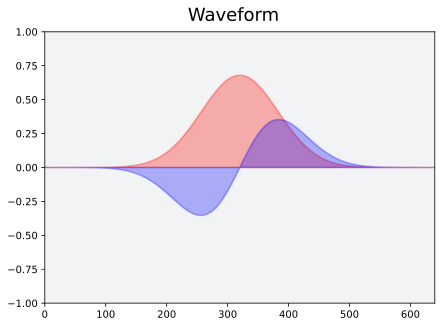

In [10]:
from qiskit.pulse import library

pulse = library.Waveform(my_pulse, name="Waveform")
pulse.draw()

In [12]:
%config InlineBackend.figure_format = 'svg'
from pulseviz import ScheduleEditor

In [13]:
sch = ScheduleEditor()
sch

In [14]:
sch.dummy_pulse = my_pulse

In [ ]:
plt.step(np.linspace(0,save_btn.my_pulse.size,save_btn.my_pulse.size),np.real(save_btn.my_pulse),
         np.linspace(0,save_btn.my_pulse.size,save_btn.my_pulse.size),np.imag(save_btn.my_pulse),
         np.linspace(0,save_btn.my_pulse.size,save_btn.my_pulse.size),np.absolute(save_btn.my_pulse))

In [ ]:
t1, i_sig1, q_sig1 = sig_gen(wf_in_dd.value, i_wf_dd.value, q_wf_dd.value, 
                              samples_sldr.value, i_amp_sldr.value, q_amp_sldr.value, i_width_sldr.value, q_width_sldr.value,)


q_amp_max = find_qamp_max(i_sig1,q_sig1)
q_amp_max

In [ ]:
q_max_val = max(abs(q_sig1)) # Find maximum of the abs of quad signal (taking abs to account for minimum too)
q_max_val

In [ ]:
q_max_ind = [i for i, x in enumerate(abs(q_sig1)) if x == q_max_val] # indices of maxima in abs quad signal
q_max_ind

In [ ]:
iamp_max = max(abs(i_sig1[q_max_ind]))   # evaluate in-phase sig at indices of quad max,
                                            # and find largest value
iamp_max

In [ ]:
np.sqrt(0.04752802165209142**2+0.998867339183008**2)

In [ ]:
tim = np.linspace(0,640,640)
ga = 1*np.exp(-((tim-640/2)/(2*10))**2)
plt.plot(tim,ga)

In [ ]:
tim = np.linspace(0,1280,1280)
ga1 = 1*np.cos(2*np.pi*1*tim-np.pi)
ga2 = 1*np.cos(2*np.pi*1*tim)
plt.plot(tim,ga1, tim, ga2)

In [ ]:
1*np.sin(2*np.pi*1*(tim[0]-max(tim)/3))

In [ ]:
tim = np.linspace(0,129,129)
widt = 2

In [ ]:
init_del = int(np.floor((tim.size-widt)/2))
fin_del = tim.size-widt-init_del

In [ ]:
init_del

In [ ]:
widt

In [ ]:
fin_del

In [ ]:
63+3+63

In [ ]:
sig = np.zeros(init_del)

In [ ]:
np.zeros(0)

In [ ]:
tim = np.linspace(0,10,10)
ga1 = -(tim-max(tim)/2)*np.exp(-1/2*((tim-max(tim)/2)/128)**2)
ga1 = ga1/max(ga1)
plt.step(tim,ga1,'r')
plt.fill_between(tim,ga1, color='r', alpha=0.2)

In [ ]:
a = np.array([])
a

In [ ]:
b = np.array([5,8,9,0])
a.concatenate((a,b))
a

In [ ]:
a = 0
a = (a+1)%2
a

In [ ]:
a = (a+1)%2
a

In [ ]:
a = (a+1)%2
a

In [ ]:
samps = 101

init_del = int(np.floor(samps/10))
init_del

In [ ]:
rect_width = samps - 2*init_del
rect_width

In [ ]:
fin_del = samps-rect_width-init_del
fin_del

In [ ]:
t_init = np.linspace(0,init_del,init_del)
t_init.size

In [ ]:
np.ones(rect_width).size

In [ ]:
t_fin = np.linspace(init_del+rect_width,init_del+fin_del+rect_width,fin_del)
t_fin.size

In [ ]:
t_fin

In [ ]:
t = np.linspace(0,101,101)
samps = 101
width = 20
amp = 0.5


init_del = int(np.floor(samps/5))
rect_width = samps - 2*init_del
fin_del = samps-rect_width-init_del

t_init = np.linspace(0,init_del,init_del)
t_fin = np.linspace(init_del+rect_width,init_del+fin_del+rect_width,fin_del)

sig = amp*np.exp(-1/2*((t_init-init_del)/width)**2)
sig_init = amp*np.exp(-1/2*((t_init-init_del)/width)**2)
sig = np.append(sig,amp*np.ones(rect_width))
sig_fin = amp*np.exp(-1/2*((t_fin-fin_del)/width)**2)
#sig = np.append(sig, sig_fin)

plt.plot(t[0:81],sig)

In [ ]:
init_del

In [ ]:
t_fin

In [ ]:
np.ones(rect_width).size

In [ ]:
sig.size

In [ ]:
init_del

In [ ]:
max(t_init)